In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from capoptix.data_loader import DataLoader

from capoptix.energymarkets.wholesale_energy_markets import RTM
from capoptix.nodal_price_generator import NodalPriceGenerator

from capoptix.generation.solar import SolarGeneration
from capoptix.generation.wind import WindGeneration
from capoptix.generation.fossils import FossilFuelGeneration
from capoptix.generation.capacity_provider import CapacityProvider

from capoptix.consumption.consumption import Consumption

from capoptix.shortfall import ShortfallAnalyzer

from capoptix.premia_model import CapacityPremiaModel 

from capoptix.utils import check_and_handle_missing_data

In [2]:
data_loader = DataLoader(filepath="NewYork_energy_data.csv")
data= data_loader.load_data()
data_loader.check_price_data()

False

In [3]:
data.columns

Index(['timestamps', 'wind_generation', 'fossil_generation', 'total', 'prices',
       'consumption', 'hour', 'day', 'month', 'year', 'minutes'],
      dtype='object')

In [4]:
data = check_and_handle_missing_data(data, columns=['prices',"fossil_generation",'wind_generation','consumption'], trendfill=True,drop_streaks=False).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842118 entries, 0 to 842117
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamps         842118 non-null  datetime64[ns]
 1   wind_generation    842118 non-null  float64       
 2   fossil_generation  842118 non-null  float64       
 3   total              842118 non-null  float64       
 4   prices             842118 non-null  float64       
 5   consumption        842118 non-null  float64       
 6   hour               842118 non-null  int64         
 7   day                842118 non-null  int64         
 8   month              842118 non-null  int64         
 9   year               842118 non-null  int64         
 10  minutes            842118 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(5)
memory usage: 70.7 MB


In [5]:
prices = RTM(data).get_market_data()

In [6]:
wind = WindGeneration(data)
fossil = FossilFuelGeneration(data)
capacity_provider = CapacityProvider(data)
capacity_provider.add_source(wind)
capacity_provider.add_source(fossil)

demand = Consumption(data)

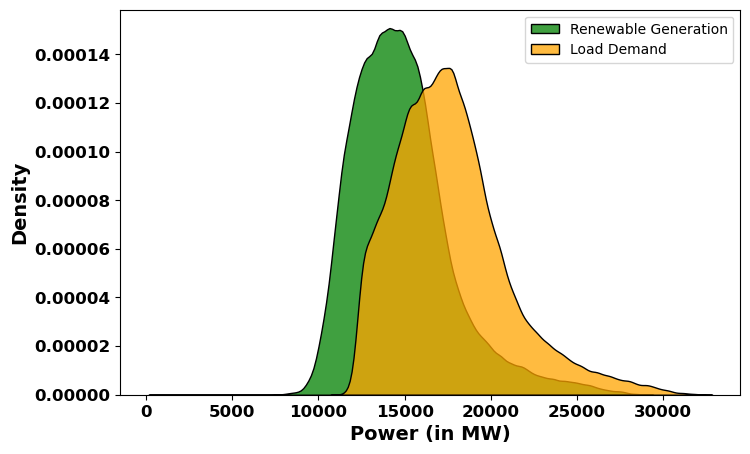

In [7]:
plt.figure(figsize=(8,5))
sns.kdeplot(capacity_provider.get_total_generation(), color= 'g',fill= True, multiple="stack")
sns.kdeplot(demand.get_consumption_data(),color = 'orange', fill= True, multiple="stack" )
plt.legend(["Renewable Generation", "Load Demand"])
plt.ylabel("Density", fontsize= 14, fontweight='bold')
plt.xlabel("Power (in MW)", fontsize = 14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
# plt.grid()
plt.show()

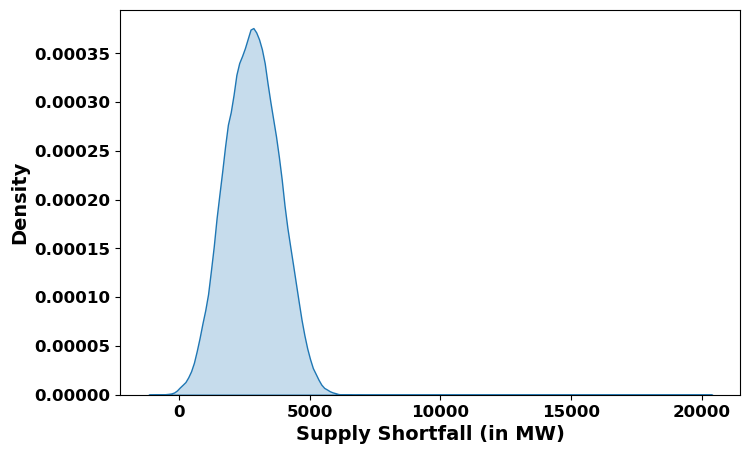

In [12]:
shortfall = ShortfallAnalyzer(capacity_provider, demand).shortfall_data
shortfall_normalized = ShortfallAnalyzer(capacity_provider, demand,"normal").shortfall_data


plt.figure(figsize=(8,5))
sns.kdeplot(shortfall, fill= True)
plt.ylabel("Density", fontsize= 14, fontweight='bold')
plt.xlabel("Supply Shortfall (in MW)", fontsize = 14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
# plt.grid()
plt.show()

<Axes: xlabel='QQ_Shortfall', ylabel='Density'>

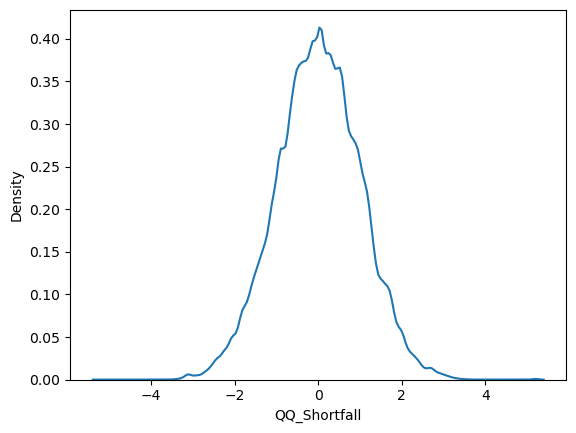

In [13]:
sns.kdeplot(shortfall_normalized)

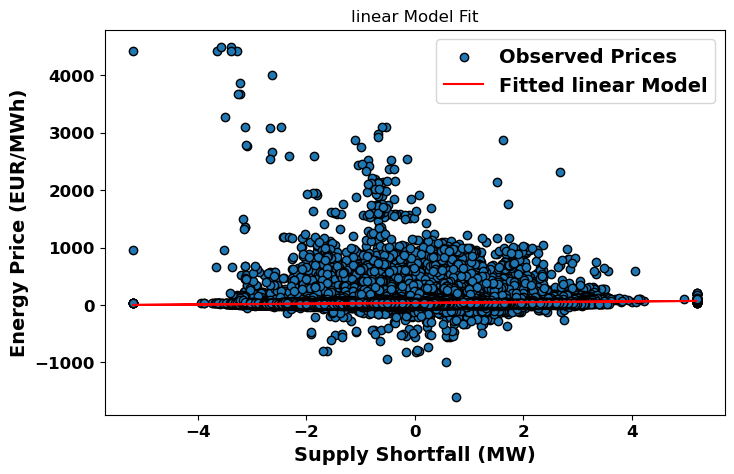

In [14]:
X=shortfall_normalized
Y=prices

nodal_price_generator = NodalPriceGenerator(X,Y)
predicted_prices=nodal_price_generator.fit_model('linear')
nodal_price_generator.plot_model_fit()

<Axes: ylabel='Density'>

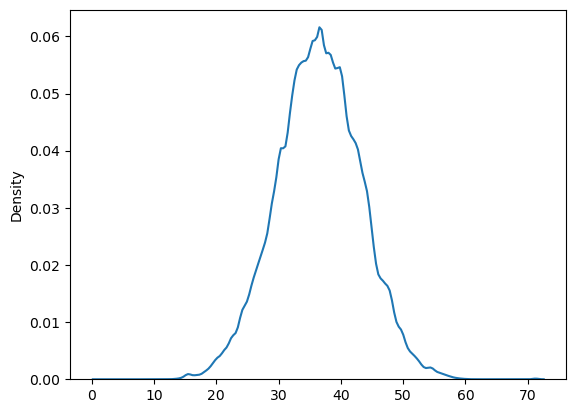

In [15]:
nodal_prices = predicted_prices
sns.kdeplot(nodal_prices)
# sns.kdeplot(prices)

In [16]:
nodal_prices.describe()

count    842118.000000
mean         36.446247
std           6.708155
min           1.503665
25%          32.000255
50%          36.489874
75%          40.934116
max          71.260307
dtype: float64

In [43]:
nodal_prices

0         33.528300
1         34.580086
2         35.249921
3         35.249921
4         35.363994
            ...    
842113    32.921134
842114    32.233745
842115    31.536934
842116    32.314712
842117    32.908423
Length: 842118, dtype: float64

In [45]:
# estimation from raw increments
delta_t = 1
increments = np.diff(nodal_prices)
mu_est = np.nanmean(increments) / delta_t
sigma_est = (np.nanstd(increments) / np.sqrt(delta_t))


T=2  #Time to expiration : 2 years from now - time for building infrastructure
sigma = sigma_est #volatility of the wholesale energy price increments
K = np.mean(nodal_prices)       #  Strike Price
r = (2.64/100)        #  Risk-free rate - from government

wholesaleenergyprice = K   #initial wholesale energy price

tau =10*365*24 #contract period of 10 years after the expiration timeline

model=CapacityPremiaModel("bachelier")
call_price, optionp, premiums = model.premia_calculation(wholesaleenergyprice, K, r, T, tau, sigma = sigma)
print(f"the call price: {call_price}")

the call price: 530990.7040859873


In [49]:
K

36.44624653851604

In [50]:
call_price/(2*12)

22124.61267024947

In [21]:
sigma_est

0.5421223627721979

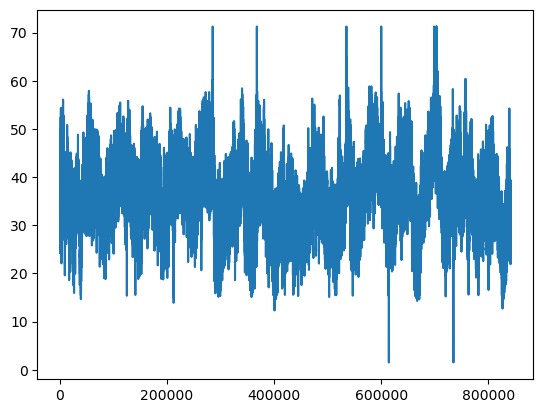

In [22]:
plt.plot(nodal_prices)

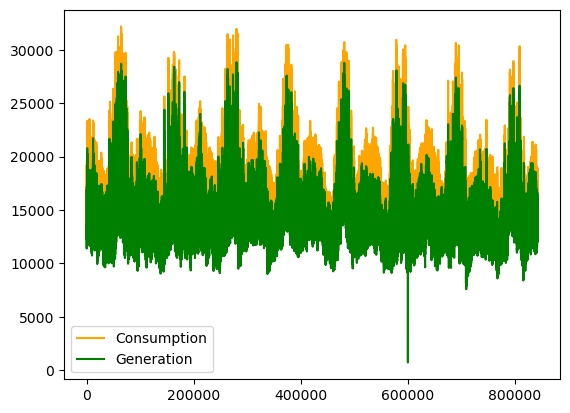

In [23]:
plt.plot(demand.get_consumption_data(),color = 'orange', label = "Consumption")
plt.plot(capacity_provider.get_total_generation(), color= 'g', label="Generation")
plt.legend()


In [ ]:
# import numpy as np

# # Parameters
# n_paths = 10000  # Number of Monte Carlo paths
# n_steps = 252  # Time steps
# T = 2  # Time to maturity (in years)
# t=2
# tau = 10*365*24
# r = (2.64/100)  # Risk-free rate
# theta = 0.8  # Mean-reversion speed
# mu = 30  # Long-term mean
# sigma = 22  # Volatility
# lambda_jump = 0.02  # Jump intensity
# jump_mean = 200  # Mean jump size
# jump_std = 300  # Std dev of jump size
# K = np.mean(nodal_prices)  # Strike price
# S0 = K # Initial price


# dt = T / n_steps
# hours_in_a_year = 365*24

# # Simulate paths
# prices = np.zeros((n_paths, n_steps))
# prices[:, 0] = S0

# for i in range(1, n_steps):
#     dW = np.random.normal(0, np.sqrt(dt), n_paths)
#     jumps = (np.random.poisson(lambda_jump * dt, n_paths) *
#              np.random.normal(jump_mean, jump_std, n_paths))
#     prices[:, i] = prices[:, i-1] + theta * (mu - prices[:, i-1]) * dt + sigma * dW + jumps

# # Compute payoff
# payoffs = np.maximum(prices[:, -1] - K, 0)  # European call payoff

# option_price = 0
# for time in range(tau):
#     maturity = (time/hours_in_a_year) + t
#     option_price += np.exp(-r * maturity) * np.mean(payoffs)

# print(f"Option Price: {option_price}")
# print(f"Option Price per month for first 2 years: {option_price/((2*12))}")

Option Price: 697952.349702709
Option Price per month for first 2 years: 29081.34790427954
